In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.model_selection as cross_validation
import sklearn.metrics as metrics
import sklearn.tree as tree
import seaborn as sns
import matplotlib.pyplot as plt
import math

In this blog post I will show you how to slice'n dice the data set from [Adult Data Set MLR](https://archive.ics.uci.edu/ml/datasets/Adult) which contains income data for about 32000 people. We will look at the data and build a machine learning model, which tries to predict if a person will make more than $50K a year, given data like education, gender and martial status.

Let's first import some libraries that we are going to need for our analysis

First we need to read the data from the file, which contains comma separated columns. With the command below we will read the data skipping any spaces before/after the commans and mark the values '?' as missing data points.

## Load the data

In [3]:
original_data = pd.read_csv(
    "datasets/adult.data",
    names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        sep=r'\s*,\s*',
        engine='python',
        na_values="?")
original_data.tail()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


## Analyze the data

Let's plot the distribution of each feature, so that we have a better understanding what we have in our data. We draw the number of values for each category feature and the histogram of the values for each continuous feature.

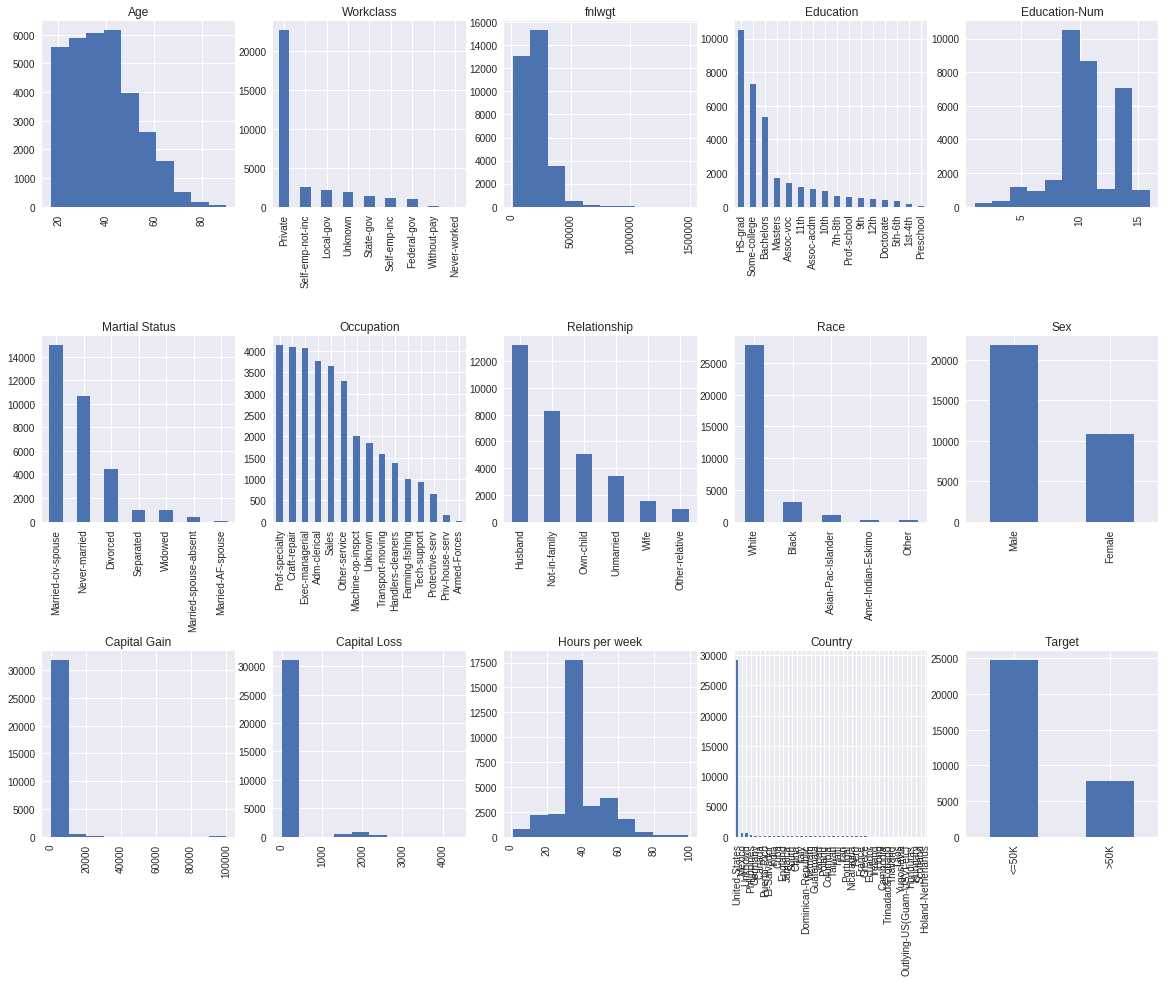

In [4]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(original_data.shape[1]) / cols)
for i, column in enumerate(original_data.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if original_data.dtypes[column] == np.object:
        original_data[column].value_counts().plot(kind="bar", axes=ax)
    else:
        original_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

As you can see from the plots above our data is mostly concentrated in the USA with mostly male white people. This is a good thing to notice, as it may impact the conclusions we come to later.

In [5]:
(original_data["Country"].value_counts() / original_data.shape[0]).head()

United-States    0.895857
Mexico           0.019748
Unknown          0.017905
Philippines      0.006081
Germany          0.004207
Name: Country, dtype: float64

Indeed! 89% of the samples are for people from the US. Mexico comes next
with less than 2%.

Now, let's explore something else. The correlation between the different
features. Generally it is not a good idea to have many correlated features, as
it might be a sign that your data is not very good. For this purpose
we will need to encode the categorical features as numbers. This can be done
using the `LabelEncoder` in the `scikit-learn` package.

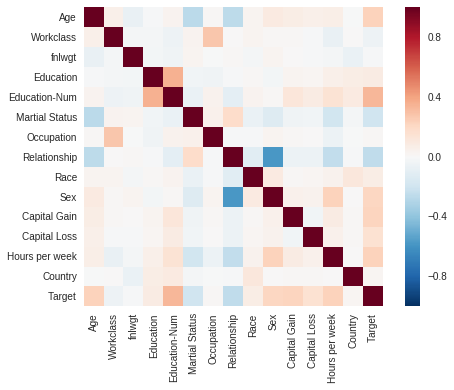

In [6]:
# Encode the categorical features as numbers
def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders
        
# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

We see there is a high correlation between `Education` and `Education-Num`. Let's look at these columns

In [7]:
original_data[["Education", "Education-Num"]].head(15)

,Education,Education-Num
0,Bachelors,13
1,Bachelors,13
2,HS-grad,9
3,11th,7
4,Bachelors,13
5,Masters,14
6,9th,5
7,HS-grad,9
8,Masters,14
9,Bachelors,13


As you can see these two columns actually represent the same features, but encoded as strings and as numbers. We don't need the string representation, so we can just delete this column. Note that it is a much better option to delete the `Education` column as the `Education-Num` has the important property that the values are ordered: the higher the number, the higher the education that person has. This is a vaulable information a machine learning algorithm can use.

In [8]:
del original_data["Education"]

So it seems that the data is mostly OK with the exception of `Sex` and `Relationship`, which seems to be negatively correlated. Let's explore that for a bit

In [9]:
original_data[["Sex", "Relationship"]].head(15)

,Sex,Relationship
0,Male,Not-in-family
1,Male,Husband
2,Male,Not-in-family
3,Male,Husband
4,Female,Wife
5,Female,Wife
6,Female,Not-in-family
7,Male,Husband
8,Female,Not-in-family
9,Male,Husband


Yes. The data looks correlated, because for example `Male` and `Husband` are highly correlated values, as well as `Female` and `Wife`. There is no easy way to tackle this problem, so let's carry on.

## Build a classifier

Now that we explored our data, let's try to build a classifier which tries to predict what will be the income of a given person given the features we have in our dataset.

First we need to encode the features as numbers as the classifiers cannot work with string features. As we saw a while ago this can be achieved easily with the function we defined earlier. Let's encode the data and show the histograms of the values again.

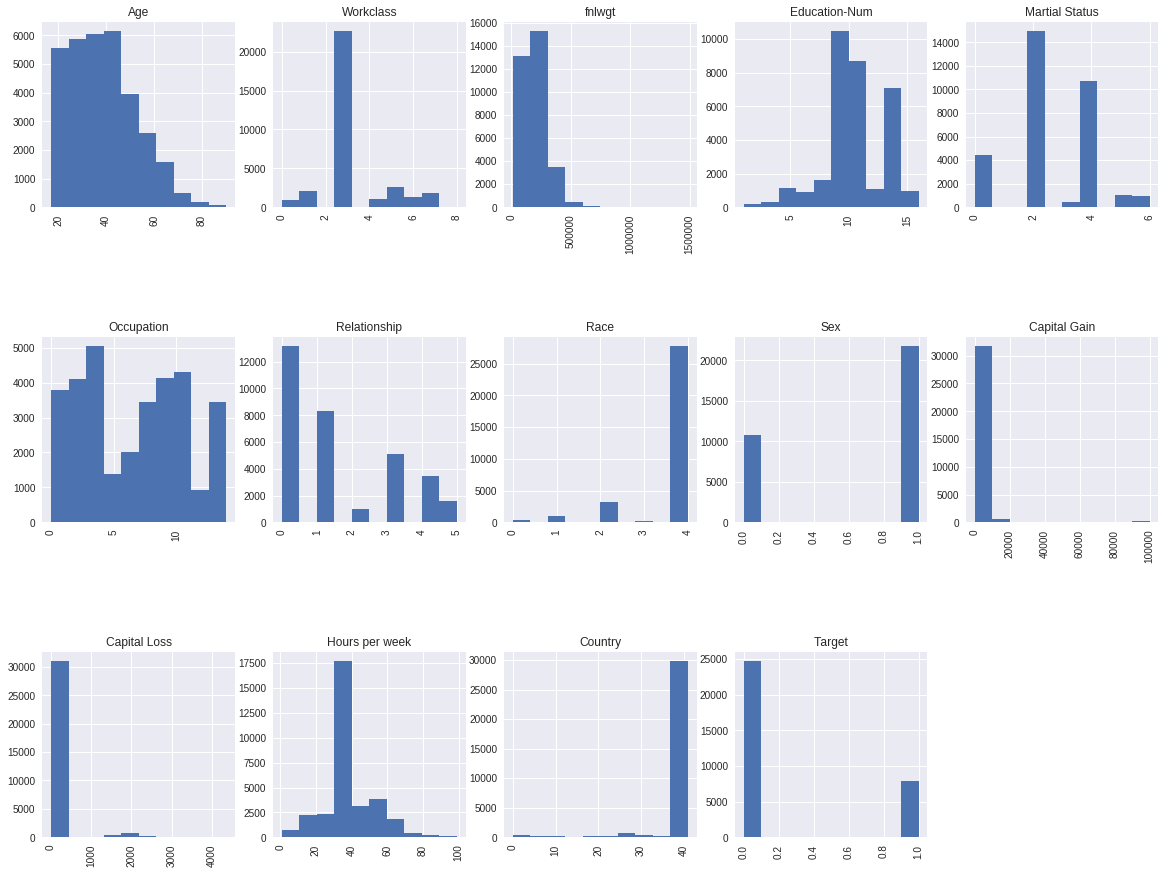

In [10]:
encoded_data, encoders = number_encode_features(original_data)
fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(encoded_data.shape[1]) / cols)
for i, column in enumerate(encoded_data.columns):
    if not encoded_data[column].empty:
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        encoded_data[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

As you can see we have our data properly encoded and it seems to make sense. Now, let's try to build a classifier for it. Before we do that, let's split the data into a train and test set. This is a common approach to avoid overfitting. If we train and test the classifiers on the same data we will always get awesome results and we will most probably overfit the model. However if we test a classifier on data it has never seen we can be more confident it will perform better when ran on new data.

## Split and scale the features

Most machine learning algorithms like the features to be scaled with mean 0 and variance 1. This is called "removing the mean and scaling to unit variance". This can be easily done with the `StandardScaler` from `scikit-learn`. Let's scale the features and look at them again.

In [11]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(encoded_data[encoded_data.columns[1:-1]], encoded_data["Target"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train.astype("float64")), columns=X_train.columns)
X_test = scaler.transform(X_test.astype("float64"))

### Logistic regression

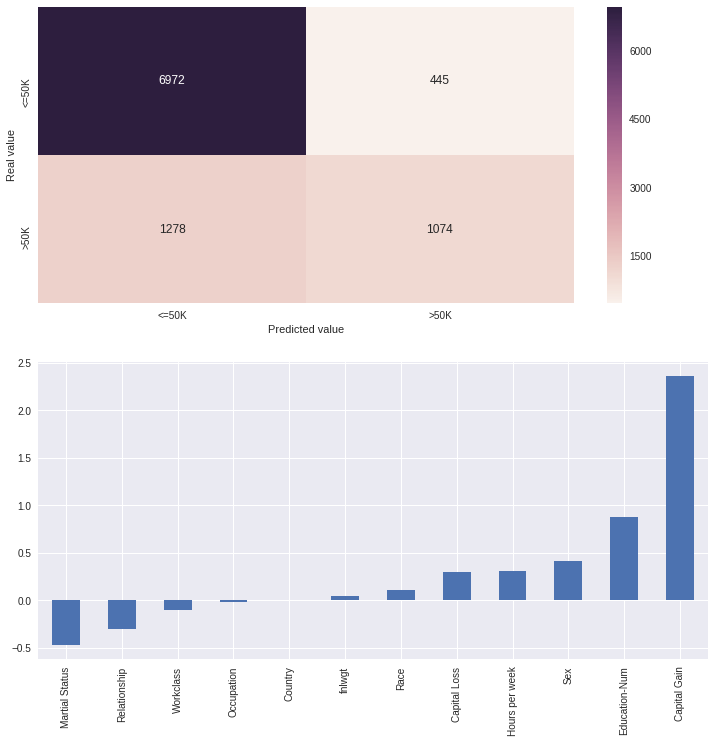

In [12]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)
y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
#print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred)
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values(inplace=True)
plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

As you can see we managed to achieve F1 score of 0.55 and the features that seems to contribute most positevely to have an income of more than $50K are `Capital Gain`, `Education-Num` and `Sex`, while the features that contribute most negatively are `Martia Status` and `Relationship`. There is a problem here, though. Features like `Martial Status` have values ranging from 0 to 6 and the order is really important here. In practice there is no particular order in that feature (unline `Education-Num` for which the higher the number, the better the education). We can fix this using *binary features*.

### Classify using binary features

As a last step we can try to improve our classifier using binary attributes. Our current approach for encoding our data has the drawback that we put arbitrary order in our classes. For example we encode `Relationship` with a number between 1 and 5 and the logistic regression interprets these values as continuous variables and plugs them into an optimization function. This will cause different classes to have different weight into our model, which is not correct. Each class is theoretically equally weighted compared to the rest of the classes. In order to fix this we can use dummy variables.

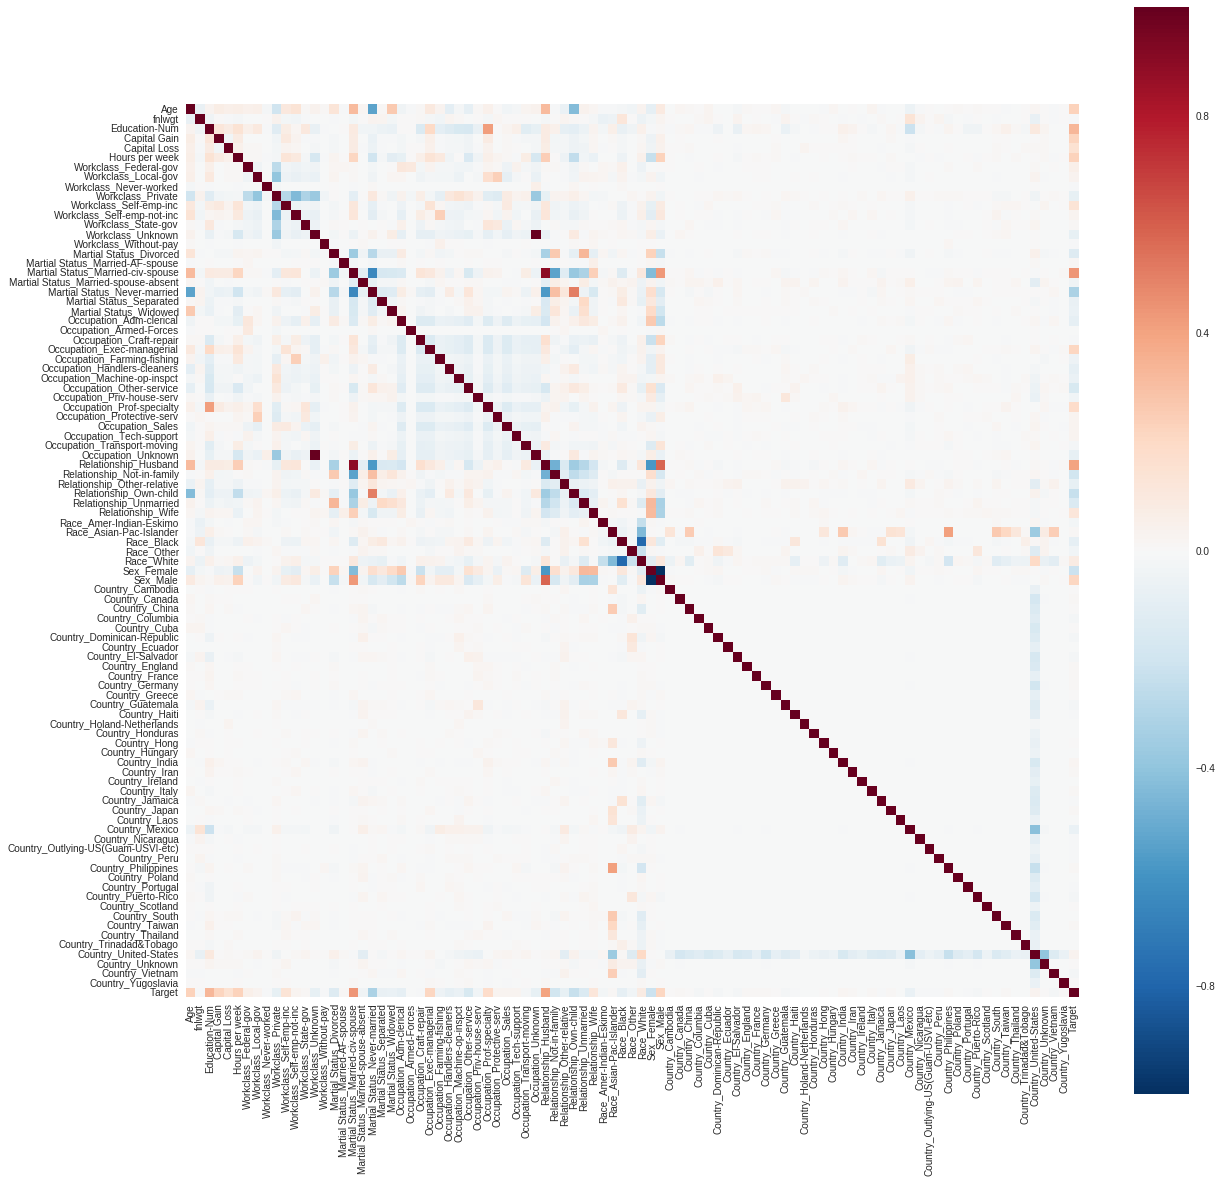

In [13]:
binary_data = pd.get_dummies(original_data)
# Let's fix the Target as it will be converted to dummy vars too
binary_data["Target"] = binary_data["Target_>50K"]
del binary_data["Target_<=50K"]
del binary_data["Target_>50K"]
plt.subplots(figsize=(20,20))
sns.heatmap(binary_data.corr(), square=True)
plt.show()

Now we have a bunch of features that have only the values 0 and 1. There is a lot of correlation between some of them, but let's not look at this for now (for example Male and Female are negatively correlated).

In [14]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(binary_data[binary_data.columns[1:-1]], binary_data["Target"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

### Logistic Regression

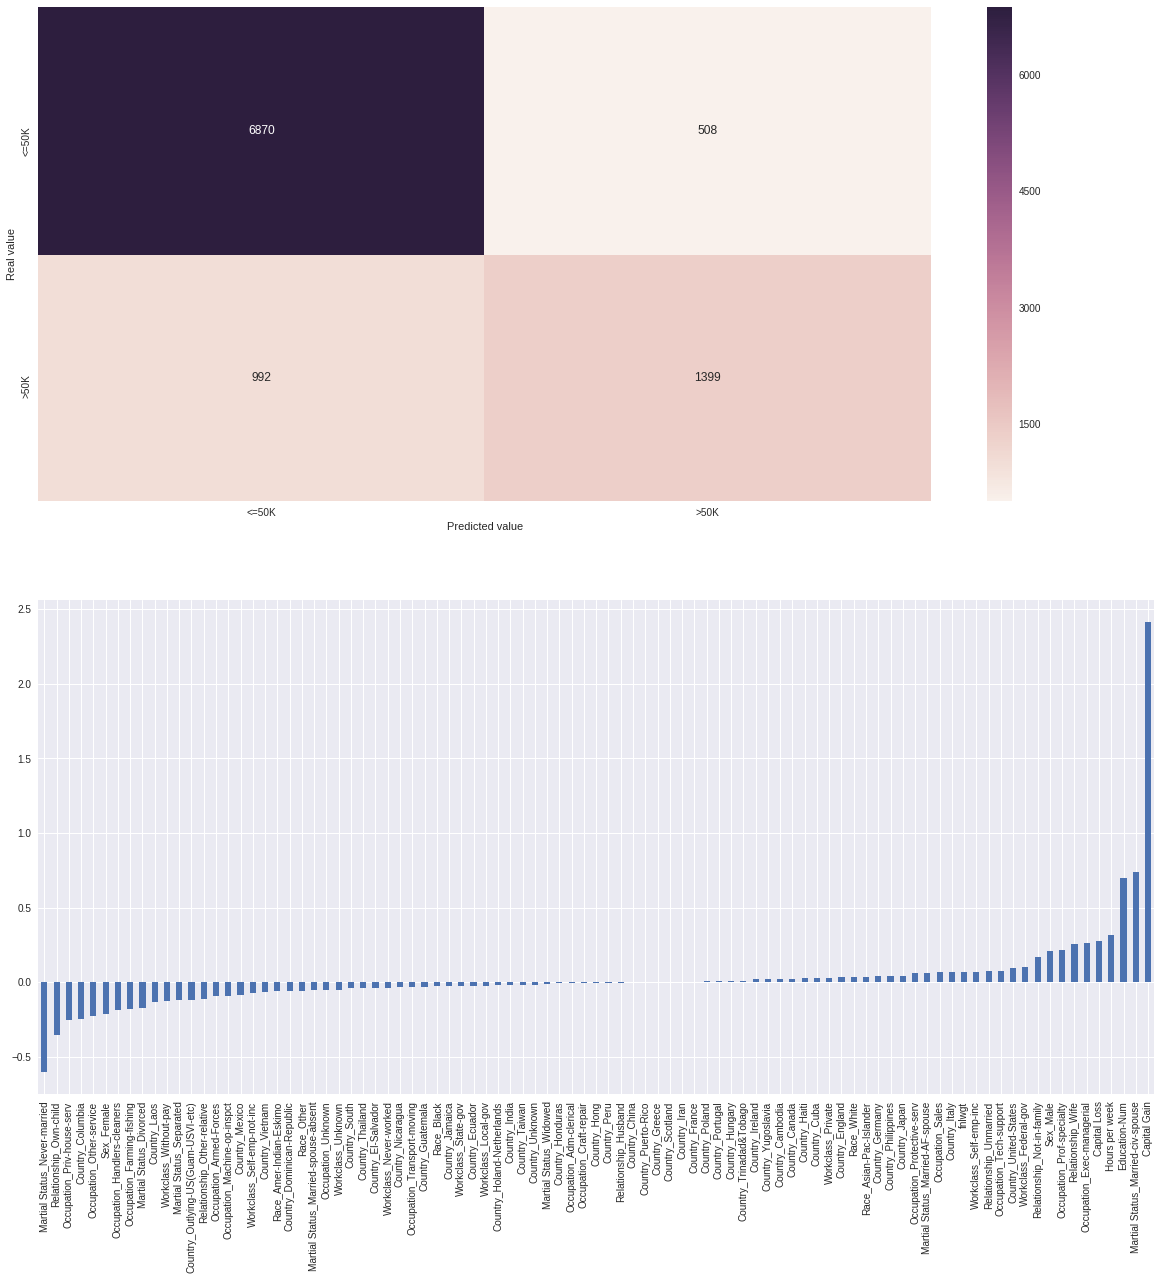

In [15]:
cls = linear_model.LogisticRegression()

cls.fit(X_train, y_train)


y_pred = cls.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=encoders["Target"].classes_, yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
#print "F1 score: %f" % skl.metrics.f1_score(y_test, y_pred)
coefs = pd.Series(cls.coef_[0], index=X_train.columns)
coefs.sort_values(inplace=True)
ax = plt.subplot(2,1,2)
coefs.plot(kind="bar")
plt.show()

# Summary

We managed to improve the F1 score significantly by converting the data to use
dummy variables. Also it seems that we managed to uncover some interesting
insign from our model. It seems that the features that impacts the income of a
person positevely are `Capital Gain`, `Married-civ-spounce`, `Age`, `Hours per
week` and `Exec-managerial`. The features that impact it most negateively are
`Never married`, `Own child`, `Priv-house-serv`, `Divorsed` and unfortunately
`Female`. One more proof that there is a gender inequality in our society.

As you can see we not only managed to build a machine learning model that we can
use to classify new data, but we also managed to uncover some interesting
insigns from our data. This is one of the nice features of the linear models.
They are not "black boxes", like neural networks for example and allow to see
what exactly the model is doing.

### Now, let's try the same with a random forest

[  2.77839401e-01   1.14520614e-01   8.36891200e-02   2.55086071e-02
   1.07155249e-01   4.63612636e-03   5.09525175e-03   7.33888222e-08
   7.13243655e-03   5.62290381e-03   7.37134246e-03   4.11055363e-03
   1.83494168e-03   2.11625543e-04   7.26048115e-03   4.86469277e-04
   3.61327927e-02   8.15566062e-04   3.14130143e-02   1.83628733e-03
   1.40964954e-03   4.41197178e-03   3.33870242e-05   5.94540423e-03
   2.24772804e-02   4.32133494e-03   5.31939123e-03   3.65589114e-03
   9.88999016e-03   2.96352520e-04   2.58523558e-02   2.16942804e-03
   4.09082080e-03   3.43156983e-03   3.72368149e-03   2.44874450e-03
   3.22016052e-02   1.45045831e-02   2.07334446e-03   3.17799127e-02
   4.44142039e-03   1.39475271e-02   1.48975284e-03   2.98743947e-03
   4.35345770e-03   1.08542786e-03   5.70179143e-03   2.24295404e-02
   1.12314125e-02   3.26633374e-04   1.20803171e-03   6.10207665e-04
   3.16168507e-04   8.52349538e-04   2.32201537e-04   1.83101816e-04
   4.11850273e-04   1.05082320e-03

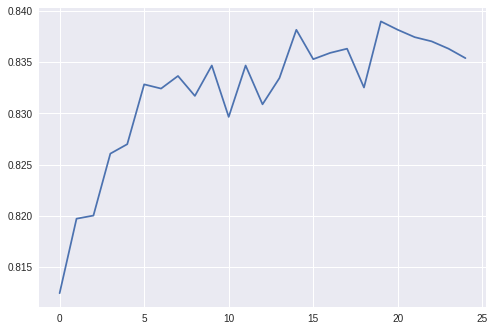

In [16]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape 
# Build model on training data
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# n_estimators is the amount of trees to build
rfClassifier=RandomForestClassifier(n_estimators=30)
# fit the RandomForest Model
rfClassifier=rfClassifier.fit(X_train,y_train)
# prediction scoring of the model (array of binary 0-1)
predictions=rfClassifier.predict(X_test)
# confusion matrix / missclassification matrix
skl.metrics.confusion_matrix(y_test,predictions)
skl.metrics.accuracy_score(y_test, predictions)


# fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
# display the relative importance of each attribute
print(model.feature_importances_)

print(max(model.feature_importances_))
max_val = np.where(model.feature_importances_ == max(model.feature_importances_))

min_val = np.where(model.feature_importances_ == min(model.feature_importances_))

print(max_val, min_val)

"""
Running a different number of trees and see the effect
 of that on the accuracy of the prediction
"""

trees=range(25)
accuracy=np.zeros(25)

for idx in range(len(trees)):
   rfClassifier=RandomForestClassifier(n_estimators=idx + 1)
   rfClassifier=rfClassifier.fit(X_train,y_train)
   predictions=rfClassifier.predict(X_test)
   accuracy[idx]=skl.metrics.accuracy_score(y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)

### So, let's predict the likelyhood that subject x earns more than 50k

### With randomForest

In [17]:
rfPrediciton = rfClassifier.predict(X_test[:1])

print(rfPrediciton)




[0]


### With logistic regression

In [18]:
lrPrediction = cls.predict(X_test[:1])

print(lrPrediction)



[0]


## Exercises

### Can we invert the data to predict Work title instead of income?
### How about age?
### Can we get better results by changing the algorithm?